In [1]:
# imports and configuration

%cd '/home/naodell/opt/nllfit/examples'
%matplotlib inline

from functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.polynomial.legendre import legval
from scipy.stats import norm, chi2
from scipy.special import erf
from tqdm import tqdm_notebook

from nllfit import Parameters, ScanParameters, Model, NLLFitter
import nllfit.fit_tools as ft
import nllfit.lookee as lee


/home/naodell/opt/nllfit/examples


# Toy example

The bump hunt search can be reduced to finding a narrow resonance on a smoothly varying background.  The most basic example could be a polynomial or exponentially dropping background with a Gaussian line shape.

In [2]:
# pdf definitions
def bg_pdf(x, a, limits):                                                          
    f = ft.legendre(x, a, xlim=limits)
    return f                                                                  

def bg_aux_cost(a):
    return np.dot(a, a)

def sig_pdf(x, a, limits):
    mu    = a[0]
    sigma = a[1]
    f     = norm.pdf(x, mu, sigma)
    A     = 0.5*(erf((limits[1] - mu)/(np.sqrt(2)*sigma)) - erf((limits[0] - mu)/(np.sqrt(2)*sigma)))
    return f/A

def mix_pdf(x, a, limits):
    f2 = sig_pdf(x, a[1:3], limits)
    f1 = bg_pdf(x, a[3:5], limits)
    f  = a[0]*f2 + (1 - a[0])*f1
    return f

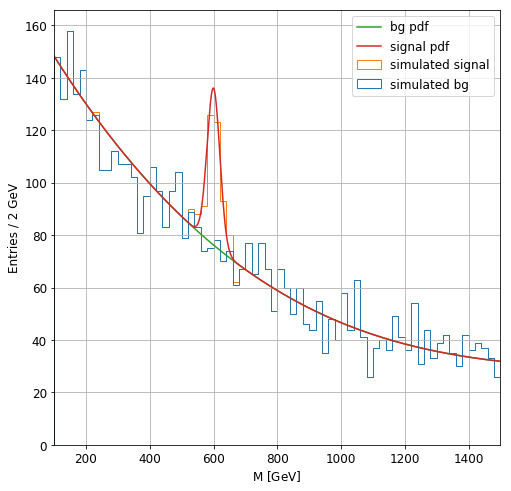

In [31]:
# model definitions
n_data = int(5e3)
limits = (100, 1500)
A      = 0.03
a      = [-0.4, 0.15, -0.02]
mu     = 600.
sigma  = 20.

x = np.linspace(limits[0], limits[1], int(1e4))
bg_true  = partial(bg_pdf, a=a, limits=limits)
sig_true = partial(sig_pdf, a=[mu, sigma], limits=limits)
bg_data  = ft.generator(bg_true, limits, (1-A)*n_data)
sig_data = ft.generator(sig_true, limits, A*n_data)
mix_data = np.concatenate([bg_data, sig_data])

# plot of toy data
plt.figure(figsize=(8,8), facecolor='white')
plt.hist([bg_data, sig_data], bins=70, range=limits, histtype='step', stacked=True)
plt.plot(x, 20*(1-A)*n_data*bg_true(x))
plt.plot(x, 20*(1-A)*n_data*bg_true(x) + 20*A*n_data*sig_true(x))

plt.xlabel(r'$\sf M\ [GeV]$')
plt.ylabel('Entries / 2 GeV')
plt.xlim(limits)

plt.legend(['bg pdf', 'signal pdf', 'simulated signal', 'simulated bg' ])
plt.show()

Next, define the background and signal models. For the background, a third-order Legendre polynomial is used.  For the signal, a Gaussian will be used, though a Voigt profile would be more accurate.  Ultimately, both are characteristically the same in that they are fully specified by the location of the central value and the width of the lineshape.  The bounds on $\mu$ and $\sigma$ should be set to correspond to the scan range.  In this case the bounds for $\mu$ are set to be 5 GeV below/above the maximum/minimum values saved in data.

In [32]:
# model initialization
null_params = Parameters()
null_params.add_many(
                     ('a1', -0.1, True, -5, 5, None),
                     ('a2', 0.1, True, -5, 5, None),
                     ('a3', -0.1, True, -5, 5, None)
                    )
null_model  = Model(partial(bg_pdf, limits=limits), null_params)
null_fitter = NLLFitter(null_model) #, aux_cost=bg_aux_cost)
null_result = null_fitter.fit(mix_data, calculate_corr=True, cov_type='hess')

alt_params = Parameters()
alt_params.add_many(
                    ('A'     , 0.01 , True , 0.0  , 1.  , None) ,
                    ('mu'    , 600. , True , 550. , 650. , None) ,
                    ('sigma' , 15.  , True , 5.   , 30.  , None)
                   )
alt_params += null_params.copy()
alt_model  = Model(partial(mix_pdf, limits=limits), alt_params)
alt_fitter = NLLFitter(alt_model)
alt_result = alt_fitter.fit(mix_data, calculate_corr=True, cov_type='bootstrap')

# print 'bg+signal result'
# sig_params.pretty_print()

Fit finished with status: 0

Calculating covariance by Hessian inversion...
[[Variables]]
    a1:  -0.38457926 +/- 0.011592 (3.01%) (init=-0.1)
    a2:   0.11813651 +/- 0.016086 (13.62%) (init= 0.1)
    a3:   0.01717891 +/- 0.017955 (104.52%) (init=-0.1)

[[Correlation matrix]]
[[ 1.    -0.355  0.117]
 [-0.355  1.    -0.311]
 [ 0.117 -0.311  1.   ]] 

Fit finished with status: 0

Calculating covariance by bootstrap...
[[Variables]]
    A:       0.02644076 +/- 0.004802 (18.16%) (init= 0.01)
    mu:      602.285967 +/- 4.143368 (0.69%) (init= 600)
    sigma:   19.0447684 +/- 3.750491 (19.69%) (init= 15)
    a1:     -0.38216499 +/- 0.011754 (3.08%) (init=-0.1)
    a2:      0.14028357 +/- 0.015917 (11.35%) (init= 0.1)
    a3:      0.01717891 +/- 9.39e-17 (0.00%) (init=-0.1)

[[Correlation matrix]]
[[  1.000e+00   7.854e-02   5.546e-01   1.531e-01   4.778e-02  -4.427e-15]
 [  7.854e-02   1.000e+00   5.334e-02   4.104e-02   9.163e-03  -6.957e-14]
 [  5.546e-01   5.334e-02   1.000e+00   1.058

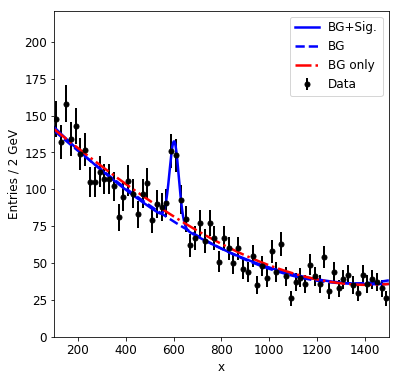

In [35]:
ft.fit_plot_1D(mix_data, alt_model, null_model, limits, nbins=70, suffix='toy')

In [37]:
qmax = 2*(null_model.calc_nll(null_result.x, mix_data) - alt_model.calc_nll(alt_result.x, mix_data))
print(np.sqrt(qmax))

7.10813702786


In [46]:
# generate simulated data
sims = ft.generator(null_model.pdf, limits, ntoys=20*n_data)
sims = sims.reshape(20, n_data)

In [47]:
# define scan parameters
sigma_max = alt_params['sigma'].value
nscans = [30, 10]
bnds   = [(limits[0]+10, limits[1]-10), (5, 30)]

scan_params = ScanParameters(names  = ['mu', 'sigma'],
                             bounds = bnds,
                             nscans = nscans
                            )

In [50]:
# carry out scans of signal parameters and cacluate EC for varying excursions

phiscan   = []
qmaxscan  = []
dofscans  = []
nllscans  = []
u_0       = np.linspace(0.2, 30., 149)
for i, sim in tqdm_notebook(enumerate(sims), 
                            desc='Scanning', 
                            unit_scale=True, 
                            ncols=75, 
                            total=len(sims)):
    # fit background model
    null_result = null_fitter.fit(sim, calculate_corr=False, verbose=False)
    if null_result.status == 0:
        nll_bg = null_model.calc_nll(null_result.x, sim)
    else:
        continue

    # scan over signal parameters
    nllscan, params, dof = alt_fitter.scan(scan_params, sim, amps=0)
    qscan = -2*(nllscan - nll_bg)
    qmaxscan.append(np.max(qscan))
    
    # for plotting detailed scan info
    nllscans.append(nllscan)
    dofscans.append(dof)

    ### Calculate E.C. of the random field
    if qscan.size != np.prod(scan_params.nscans):
        continue
        
    qscan = np.array(qscan).reshape(scan_params.nscans)
    phiscan.append([lee.calculate_euler_characteristic((qscan > u) + 0.) 
                    for u in u_0])

# convert lists to arrays
phiscan     = np.array(phiscan)
qmaxscan    = np.array(qmaxscan)

In [43]:
param_init = [1.,1.]
param_bnds = [(1., np.inf), (1., np.inf)]

kvals      = [1]
scales     = [0.5]
nvals      = lee.get_GV_coefficients(u_0, phiscan, param_init, param_bnds, kvals, scales)
nvals

ValueError: Objective function must return a scalar

In [ ]:
### Calculate statistics and print ###
p_local  = 0.5*chi2.sf(qmax, 1)
z_local  = -norm.ppf(p_local)
p_global = lee.get_p_global(qmax, [1], [nvals], [0.5])
z_global = -norm.ppf(p_global)

for i, n in enumerate(nvals.flatten()):
    print 'N{0} = {1:.2f}'.format(i+1, n)

print 'local p value       = {0:.3e}'.format(p_local)
print 'local significance  = {0:.2f}'.format(z_local)
print 'global p value      = {0:.3e}'.format(p_global)
print 'global significance = {0:.2f}'.format(z_global)
print 'trial factor        = {0:.2f}'.format(p_global/p_local)

For the sake of validating this result we can check if our prediction from the Gross-Vitells formalism compares well with the distribution from the toy data.

In [ ]:
lee.gv_validation_plot(u_0, phiscan, qmaxscan, [nvals], [1], [0.5], None)

## Higgs to ZZ to 4 leptons analysis

Now we will consider the other golden decay channel: $H\rightarrow ZZ \rightarrow 4\ell$.  This channel is distinct from the $H\rightarrow \gamma\gamma$ channel in specifics (background shape, signal shape, and overall event yield), but when it comes to hypothesis testing the two channels should be combined to determine the total significance.

Let's go through the same steps that we went through for the $H\rightarrow \gamma\gamma$ case.

In [ ]:
# get the data and plot it
df_data  = pd.read_csv('data/toy_hzz.txt')
data_hzz = df_data.inv_mass.values
n_total  = data_hzz.size

df_bg       = pd.read_csv('data/toy_hzz_bg.txt')
data_hzz_bg = df_bg.inv_mass.values[:7500]

plt.hist(data_hzz, bins=27, range=(100, 181), histtype='step')
plt.hist(data_hzz_bg, bins=27, range=(100, 181), histtype='step', weights=0.01*np.ones(data_hzz_bg.size))
plt.xlabel(r'$\sf M_{ZZ}$')
plt.ylabel('Entries / 2 GeV')
plt.xlim(100, 180)
plt.ylim(0, 25)

In [ ]:
bg_fitter.verbose = True
bg_result  = bg_fitter.fit(data_hzz_bg)
bg_params['a1'].vary   = False
bg_params['a2'].vary   = False
bg_params['a3'].vary   = False

# fix bg+signal polynomial parameters to values from bg only simulation
sig_params['a1'].value  = bg_params['a1'].value
sig_params['a2'].value  = bg_params['a2'].value
sig_params['a3'].value  = bg_params['a3'].value
sig_params['a1'].vary   = False
sig_params['a2'].vary   = False
sig_params['a3'].vary   = False

sig_result = sig_fitter.fit(data_hzz)

In [ ]:
ft.fit_plot_1D(data_hzz, sig_model, bg_model, (100, 181), nbins=27, suffix='hzz')

In [ ]:
# generate toys
sims = ft.generator(bg_model.pdf, xlimits, ntoys=500*n_total)
sims = sims.reshape(500, n_total)

# set up scan parameters
sigma_max = sig_params['sigma'].value
nscans = [30, 10]
bnds   = [(xlimits[0]+10, xlimits[1]-10), (1, 5)]
scan_params = ScanParameters(names  = ['mu', 'sigma'],
                             bounds = bnds,
                             nscans = nscans
                            )

# carry out scans over signal parameters
bg_fitter.verbose = False # turn off parameter printing
phiscan   = []
qmaxscan  = []
u_0       = np.linspace(0.01, 30., 300)
for i, sim in tqdm_notebook(enumerate(sims), 
                            desc='Scanning', 
                            unit_scale=True, 
                            ncols=75, 
                            total=len(sims)):
    # fit background model
    bg_result = bg_fitter.fit(sim, calculate_corr=False)
    if bg_result.status == 0:
        nll_bg = bg_model.calc_nll(sim)
    else:
        continue
        

    # scan over signal parameters
    nllscan, params, dof = sig_fitter.scan(scan_params, sim)
    qscan = -2*(nllscan - nll_bg)
    qmaxscan.append(np.max(qscan))

    ### Calculate E.C. of the random field
    if qscan.size != np.prod(scan_params.nscans):
        continue
        
    qscan = np.array(qscan).reshape(scan_params.nscans)
    phiscan.append([lee.calculate_euler_characteristic((qscan > u) + 0.) 
                    for u in u_0])

# convert lists to arrays
phiscan     = np.array(phiscan)
qmaxscan    = np.array(qmaxscan)

In [ ]:
param_init = [1.,1.]
param_bnds = [(0., np.inf), (0., np.inf)]
kvals      = [1]
scales     = [0.5]
nvals      = lee.get_GV_coefficients(u_0, phiscan, param_init, param_bnds, kvals, scales)

### Calculate statistics and print ###
p_local  = 0.5*chi2.sf(qmax, 1)
z_local  = -norm.ppf(p_local)
p_global = lee.get_p_global(qmax, [1], [nvals], [0.5])
z_global = -norm.ppf(p_global)

for i, n in enumerate(nvals.flatten()):
    print 'N{0} = {1:.2f}'.format(i+1, n)

print 'local p value       = {0:.3e}'.format(p_local)
print 'local significance  = {0:.2f}'.format(z_local)
print 'global p value      = {0:.3e}'.format(p_global)
print 'global significance = {0:.2f}'.format(z_global)
print 'trial factor        = {0:.2f}'.format(p_global/p_local)

lee.gv_validation_plot(u_0, phiscan, qmaxscan, [nvals], [1], [0.5], None)

This looks very good in both cases.  I will consider the case that we carry out the search in both channels simultaneously in a separate notebook.